# Using cartopy and projections for plotting

In [1]:
import s3fs
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

## Open ERA5 dataset

In [2]:
fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False, 
                           config_kwargs = {'max_pool_connections': 20})

In [3]:
files_mapper =  [s3fs.S3Map('era5-pds/zarr/2020/06/data/air_temperature_at_2_metres.zarr/', s3=fs)]

In [5]:
%%time
dset = xr.open_mfdataset(files_mapper, engine='zarr', 
                            concat_dim='time0', combine='nested', 
                            coords='minimal', compat='override', parallel=True)

CPU times: user 312 ms, sys: 14.4 ms, total: 327 ms
Wall time: 5.24 s


## Get metadata 

In [6]:
dset

<xarray.Dataset>
Dimensions:                      (lat: 721, lon: 1440, time0: 720)
Coordinates:
  * lat                          (lat) float32 90.0 89.75 89.5 ... -89.75 -90.0
  * lon                          (lon) float32 0.0 0.25 0.5 ... 359.5 359.8
  * time0                        (time0) datetime64[ns] 2020-06-01 ... 2020-0...
Data variables:
    air_temperature_at_2_metres  (time0, lat, lon) float32 dask.array<chunksize=(372, 150, 150), meta=np.ndarray>
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    title:        ERA5 forecasts

### Get variable metadata (air_temperature_at_2_metres)

In [7]:
dset['air_temperature_at_2_metres']

<xarray.DataArray 'air_temperature_at_2_metres' (time0: 720, lat: 721, lon: 1440)>
dask.array<xarray-air_temperature_at_2_metres, shape=(720, 721, 1440), dtype=float32, chunksize=(372, 150, 150), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * time0    (time0) datetime64[ns] 2020-06-01 ... 2020-06-30T23:00:00
Attributes:
    long_name:       2 metre temperature
    nameCDM:         2_metre_temperature_surface
    nameECMWF:       2 metre temperature
    product_type:    analysis
    shortNameECMWF:  2t
    standard_name:   air_temperature
    units:           K

## Select time
- Check time format when selecting a specific time 

In [12]:
dset['air_temperature_at_2_metres'].sel(time0='2020-06-30T21:00:00.000000000')

<xarray.DataArray 'air_temperature_at_2_metres' (lat: 721, lon: 1440)>
dask.array<getitem, shape=(721, 1440), dtype=float32, chunksize=(150, 150), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
    time0    datetime64[ns] 2020-06-30T21:00:00
Attributes:
    long_name:       2 metre temperature
    nameCDM:         2_metre_temperature_surface
    nameECMWF:       2 metre temperature
    product_type:    analysis
    shortNameECMWF:  2t
    standard_name:   air_temperature
    units:           K

## Visualize data

### Simple visualization from xarray plotting method

CPU times: user 6.52 s, sys: 1.34 s, total: 7.86 s
Wall time: 1min 17s


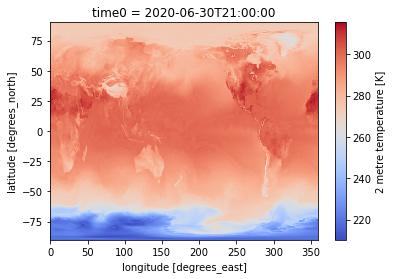

In [16]:
%%time 
dset['air_temperature_at_2_metres'].sel(time0='2020-06-30T21:00').plot(cmap = 'coolwarm')

## Save intermediate results to local disk 
- We usually need a lot of customization when plotting so before plotting, make sure to save intermediate results to disk to speed-up your work

In [18]:
%%time
dset['air_temperature_at_2_metres'].sel(time0='2020-06-30T21:00').to_netcdf("ERA5_air_temperature_at_2_metres_2020-06-30T2100.nc")

## Save netCDF file into your current galaxy history
- This approach is only valid for small datafiles, typically those you will save before plotting
- This can be helpful for sharing dataset with your colleagues or if you have to restart your JupyterLab instance

In [41]:
!put -p ERA5_air_temperature_at_2_metres_2020-06-30T2100.nc -t netcdf

#### Open local file before plotting

In [19]:
dset = xr.open_dataset("ERA5_air_temperature_at_2_metres_2020-06-30T2100.nc")

#### Same plot but with local file

CPU times: user 212 ms, sys: 7.64 ms, total: 219 ms
Wall time: 287 ms


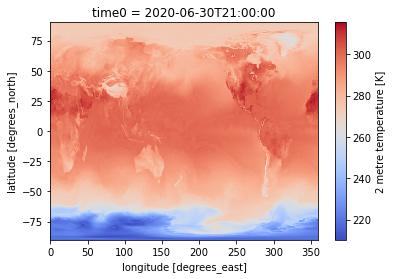

In [25]:
%%time 
dset['air_temperature_at_2_metres'].plot(cmap = 'coolwarm')

### Customize plot

#### Set the size of the figure and add coastlines 

CPU times: user 7.68 s, sys: 38 ms, total: 7.72 s
Wall time: 8.15 s


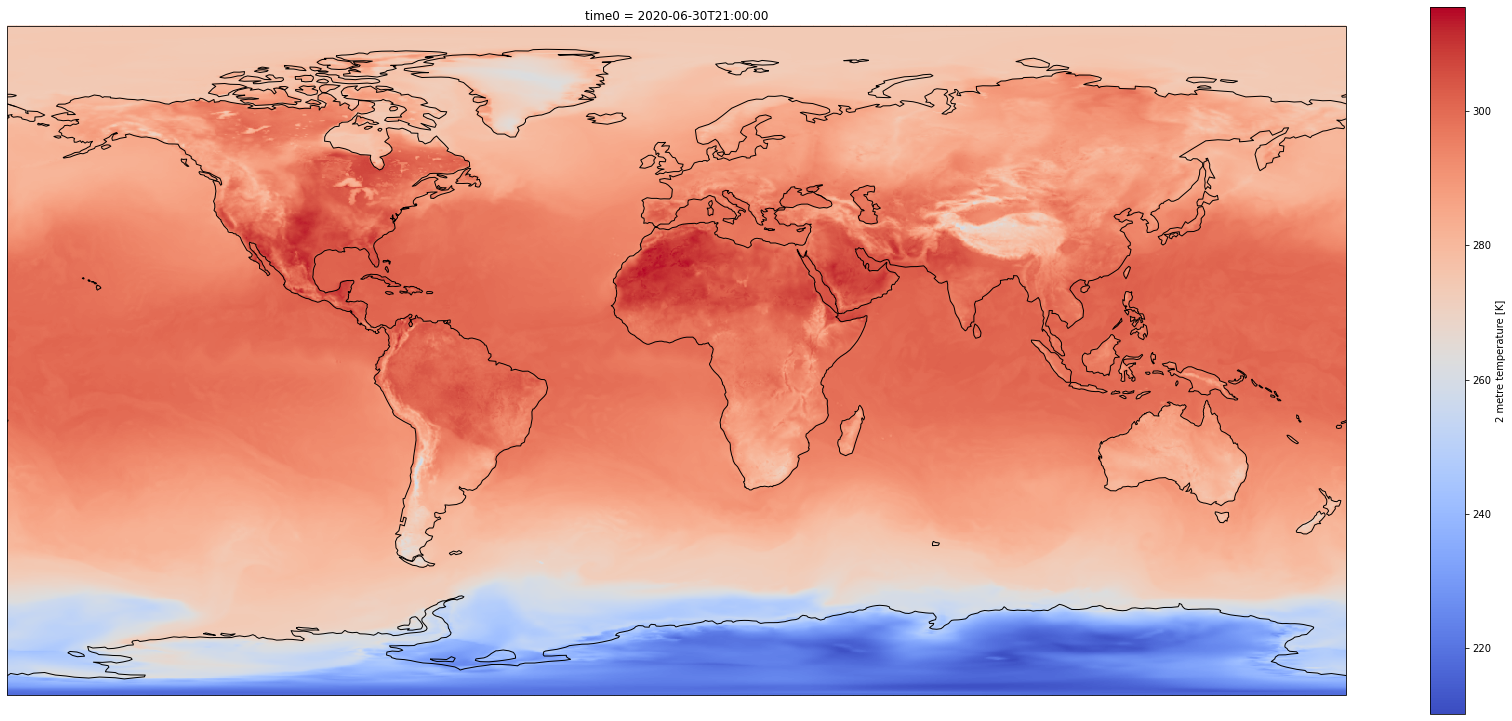

In [26]:
%%time
fig = plt.figure(1, figsize=[30,13])

# Set the projection to use for plotting
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()

# Pass ax as an argument when plotting. Here we assume data is in the same coordinate reference system than the projection chosen for plotting
# isel allows to select by indices instead of the time values
dset['air_temperature_at_2_metres'].plot.pcolormesh(ax=ax, cmap='coolwarm')

#### Change plotting projection

CPU times: user 499 ms, sys: 10.6 ms, total: 509 ms
Wall time: 592 ms


Text(0.5, 1.0, 'ERA5 air temperature at 2 metres\n 30th June 2020 at 21:00 UTC')

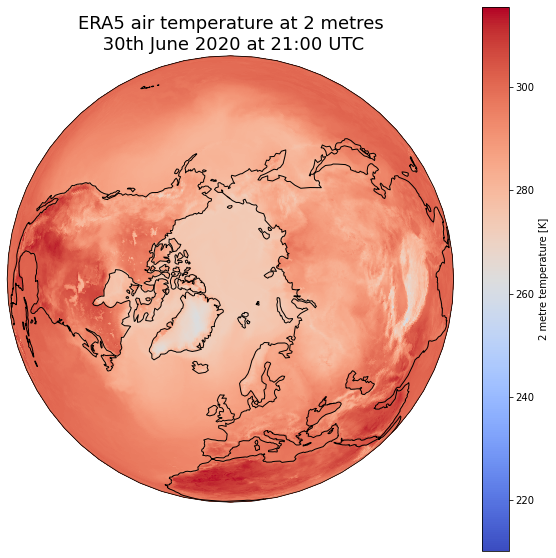

In [32]:
%%time

fig = plt.figure(1, figsize=[10,10])

# We're using cartopy and are plotting in Orthographic projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
ax.coastlines()

# We need to project our data to the new Orthographic projection and for this we use `transform`.
# we set the original data projection in transform (here PlateCarree)
dset['air_temperature_at_2_metres'].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm')

# One way to customize your title
plt.title("ERA5 air temperature at 2 metres\n 30th June 2020 at 21:00 UTC", fontsize=18)

#### Choose extent of values

CPU times: user 464 ms, sys: 4.72 ms, total: 469 ms
Wall time: 514 ms


Text(0.5, 1.0, 'ERA5 air temperature at 2 metres\n 30th June 2020 at 21:00 UTC')

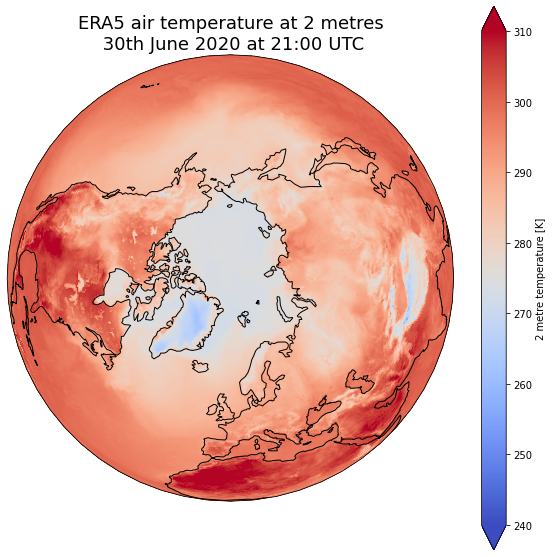

In [37]:
%%time
fig = plt.figure(1, figsize=[10,10])

ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
ax.coastlines()

# Fix extent
minval = 240
maxval = 310

# pass extent with vmin and vmax parameters
dset['air_temperature_at_2_metres'].plot(ax=ax, vmin=minval, vmax=maxval, transform=ccrs.PlateCarree(), cmap='coolwarm')

# One way to customize your title
plt.title("ERA5 air temperature at 2 metres\n 30th June 2020 at 21:00 UTC", fontsize=18)

### Combine plots with different projections 

CPU times: user 939 ms, sys: 12.9 ms, total: 952 ms
Wall time: 1.26 s


Text(0, 0.5, 'K')

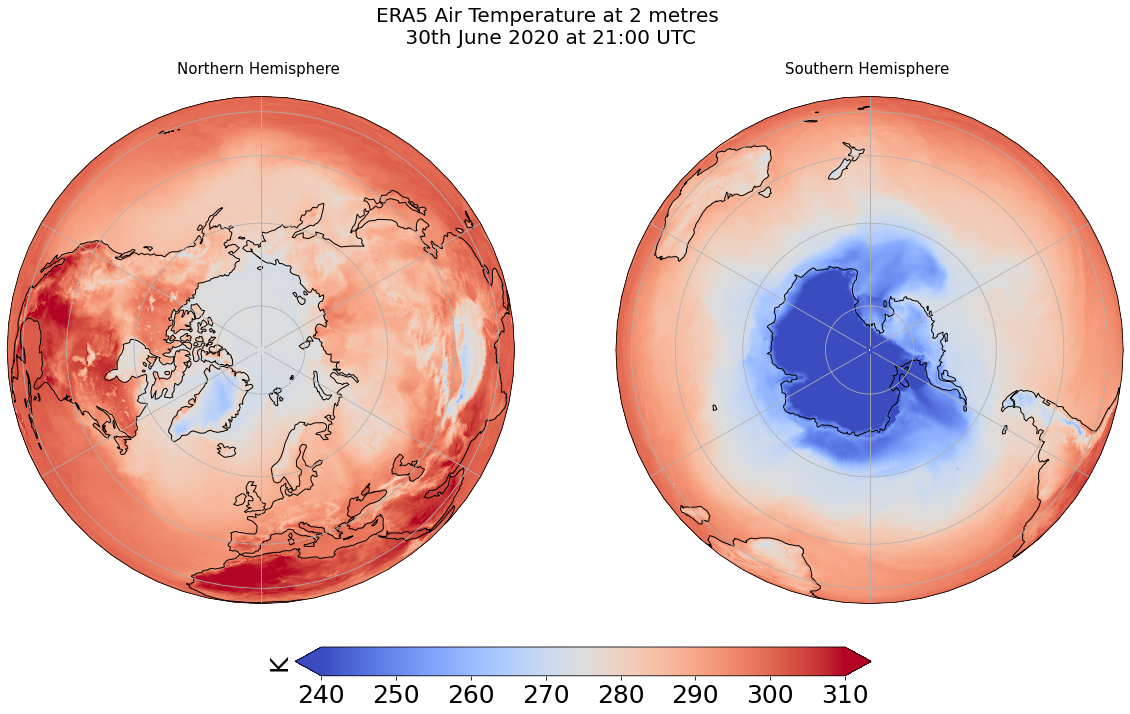

In [40]:
%%time
fig = plt.figure(1, figsize=[20,10])

# Fix extent
minval = 240
maxval = 310

# Plot 1 for Northern Hemisphere subplot argument (nrows, ncols, nplot)
# here 1 row, 2 columns and 1st plot
ax1 = plt.subplot(1, 2, 1, projection=ccrs.Orthographic(0, 90))

# Plot 2 for Southern Hemisphere
# 2nd plot 
ax2 = plt.subplot(1, 2, 2, projection=ccrs.Orthographic(180, -90))

tsel = 0
for ax,t in zip([ax1, ax2], ["Northern", "Southern"]):
    map = dset['air_temperature_at_2_metres'].plot(ax=ax, vmin=minval, vmax=maxval, 
                                           transform=ccrs.PlateCarree(), 
                                           cmap='coolwarm', 
                                           add_colorbar=False)
    ax.set_title(t + " Hemisphere \n" , fontsize=15)
    ax.coastlines()
    ax.gridlines()

# Title for both plots
fig.suptitle('ERA5 Air Temperature at 2 metres\n 30th June 2020 at 21:00 UTC', fontsize=20)


cb_ax = fig.add_axes([0.325, 0.05, 0.4, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=25)
cbar.ax.set_ylabel('K', fontsize=25)